In [4]:
# coding: utf-8
import torch
import numpy
import pandas
from nnsight import LanguageModel

from sklearn.metrics.pairwise import cosine_distances
import matplotlib.pyplot as plt
import seaborn

In [2]:
def forwardpass (model, prompt, tokens):
    layers = model.backbone.blocks
    # run the text through the model to get the baseline to
    # calculate the differences against
    with model.trace() as tracer:
        hidden_state = []
        with tracer.invoke(prompt) as invoker:
            for layer_ix in range(32):
                layer = getattr(layers, str(layer_ix))
                if layer_ix == 0:
                    layer_input = layer.input.clone().save()
                    hidden_state.append(layer_input)
                layer_output = layer.output.save()
                hidden_state.append(layer_output)

    vz_results = []
    # value zeroing
    with model.trace() as tracer:
        for token_ix in range(len(tokens)):
            token_vz_results = []
            with tracer.invoke(prompt) as invoker:
                for layer_ix in range(32):
                    layer = getattr(layers, str(layer_ix))
                    # set the layer input to the baseline                    
                    layer.input[0] = hidden_state[layer_ix][0]
                    layer_v = getattr(getattr(layer, "mlstm_layer"), "v")
                    v_output = layer_v.output
                    # set the value vector of token token_ix to 0
                    v_output[0,token_ix,:] = torch.zeros(1, 4096)
                    # save the layer output
                    layer_output = layer.output.save()
                    token_vz_results.append(layer_output)
            vz_results.append(token_vz_results)
    return hidden_state, vz_results

In [3]:
model = LanguageModel("NX-AI/xLSTM-7b", device_map="cuda")


In [4]:
tokenizer = model.tokenizer

In [5]:
#prompt = "Sarah told the author about her book"
#prompt = "The clown is playing his show tonight in the circus"
prompt = "Either you win the game, or you lose the game."
#prompt = '"I am going home," he said'
#prompt = 'Elizabeth Warren (D-MA) says she disagrees with the policies'
#prompt = 'the sum of 5 and 8 is 13'

inputs = tokenizer(prompt, add_special_tokens=True)
hidden_state, vz_hidden_state = forwardpass(model, prompt, inputs['input_ids'])


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

You're using a GPTNeoXTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [6]:
hidden_state = torch.stack([hs[0].squeeze() for hs in hidden_state]).detach().cpu()

In [7]:
token_vz = [torch.stack([lhs[0] for lhs in ths]).detach().cpu().squeeze(1) for ths in vz_hidden_state]

In [8]:
seq_length = len(token_vz)

In [9]:
score_matrix = numpy.zeros((32, seq_length, seq_length))

### value-zeroing calculations

copied and adapted from Hosein's code (https://github.com/hmohebbi/ValueZeroing/blob/57d448daf9541e88062883f8374341566e4c06ee/scoring/value_zeroing.py#L151)

In [10]:
for l in range(32):
    for t in range(seq_length):
        # get the hidden state for each layer/token
        x = hidden_state[l+1][:seq_length]
        y = token_vz[t][l][:seq_length]
        # calculate the distance
        d1 = cosine_distances(x, y)
        d2 = d1.diagonal()
        # add to the matrix
        score_matrix[l,:,t] = d2

In [11]:
# find the maximum value, and use it (rounded up) as a limit for the colour scale in our plots
vmax = numpy.round(score_matrix.max() + 0.05, decimals=1)
print(vmax)

0.2


In [12]:
input_words = tokenizer.convert_ids_to_tokens(inputs['input_ids'])
corr_ix = pandas.MultiIndex.from_product(
    [
        range(32),
        range(len(input_words)),
        range(len(input_words)),
    ], 
    names=['layer', 'token_hs', 'token_vz'])
corr_df = pandas.DataFrame(score_matrix.flatten(), columns=['activation_corr'], index=corr_ix).reset_index()


In [13]:
def draw_heatmap(columns, index, values, data=None, **kwargs):
    d = data.pivot(index=index, columns=columns, values=values)
    seaborn.heatmap(d, **kwargs)

/home/martijn/miniforge3/envs/xlstm_new/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)


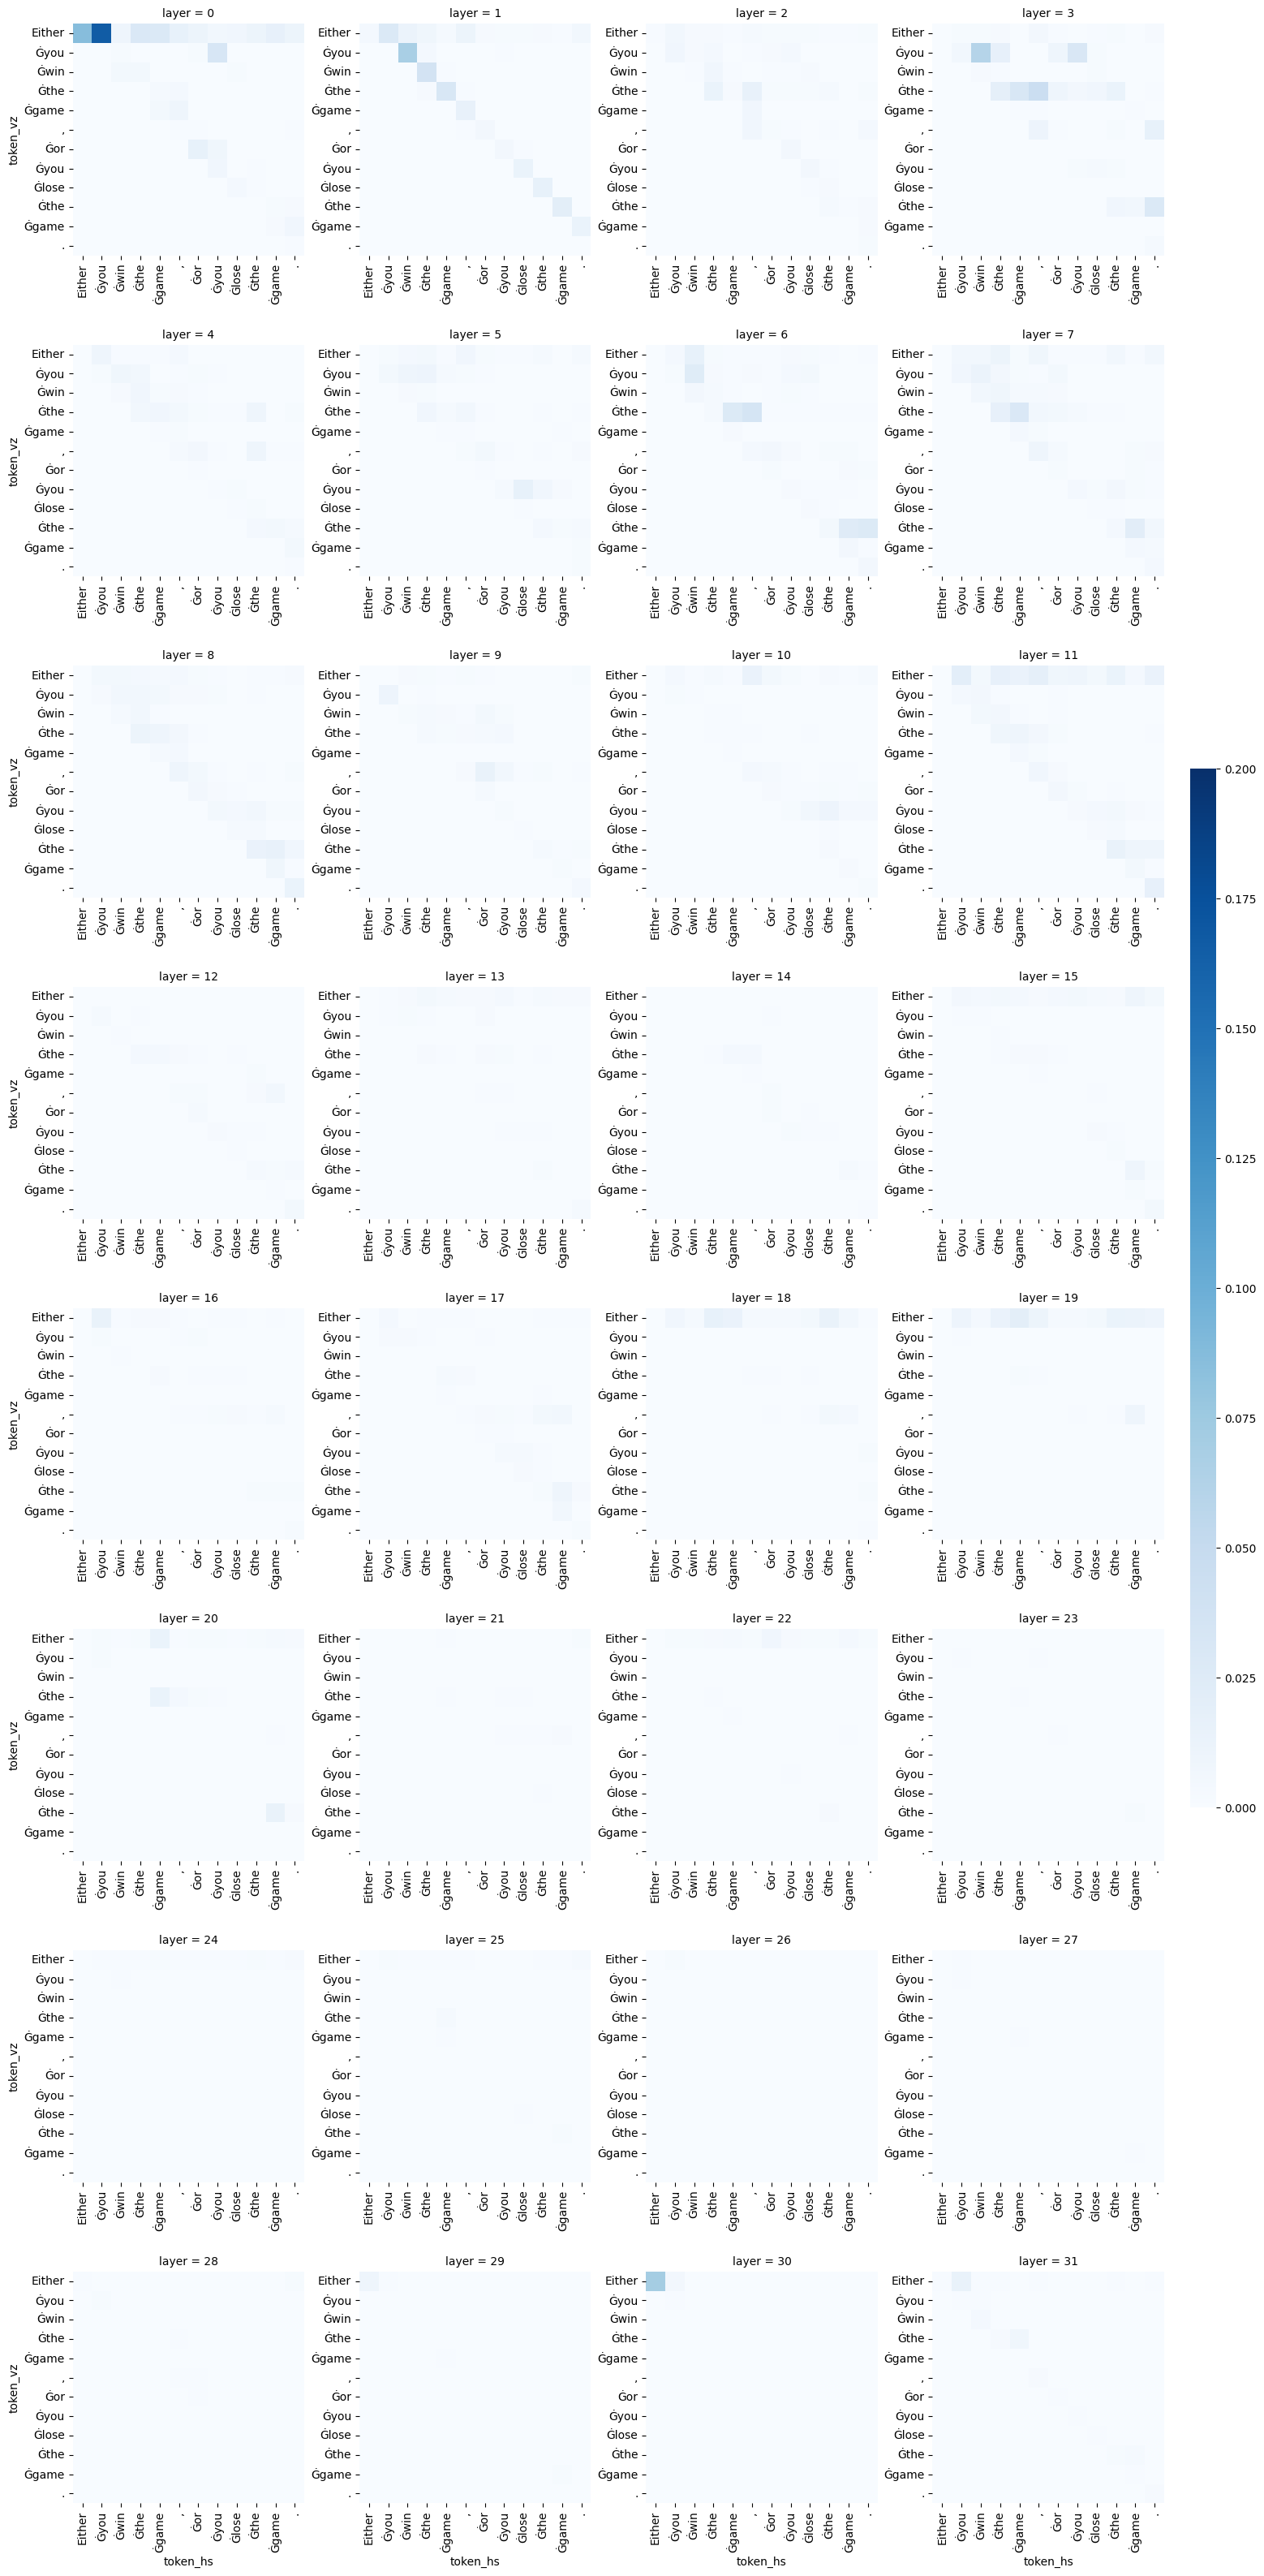

In [14]:
g = seaborn.FacetGrid(data=corr_df, col="layer", col_wrap=4, height=4, sharey=False, sharex=False)
cbar_ax = g.fig.add_axes([.92, .3, .02, .4])  # <-- Create a colorbar axes

g.map_dataframe(draw_heatmap, "token_hs", "token_vz", "activation_corr", 
        xticklabels=input_words,
        yticklabels=input_words,
        #annot=True, fmt=".3f",# annot_kws={'size': 'small'},
        cbar_ax=cbar_ax, vmin=0, vmax=vmax,
        cmap="Blues",
        square=True,
    )
g.fig.subplots_adjust(right=.9)  # <-- Add space so the colorbar doesn't overlap the plot